In [11]:

#from Tools import *
from photoObject import *
import numpy as np
import seaborn as sns
import pandas as pd
from BayesianInference import *
from random import Random
import random
from scipy.interpolate import interp1d
from scipy.stats import rv_continuous
from astropy.io import ascii
import emcee
import pathos.multiprocessing as multiproc
from multiprocessing import Pool
import corner
from IPython.display import display, Math
from astropy import cosmology
import corner
from palettable import cmocean
import matplotlib.pyplot as plt

In [12]:
Catalog=ascii.read('../../A-Catalogs/Binospec-Candels.cat')
mask=np.isnan(Catalog["EWLya"])==False
Catalog=Catalog[mask]
print(len(Catalog))
#mask=Catalog["EWLya"]<500

#Catalog=Catalog[mask]

#mask=Catalog["Muv"]<-19.5

#Catalog=Catalog[mask]

228


In [15]:
# Filter the Catalog table to find entries with fesc > 0
fesc_positive = Catalog[Catalog['dfesc'] > 0]

# Count the number of entries with fesc > 0
num_fesc_positive = len(fesc_positive)
print(f"Number of entries with fesc > 0: {num_fesc_positive}")

Number of entries with fesc > 0: 10


In [13]:
num_lae = np.sum(Detection_type == "LAE")
print(f"Number of entries with Type == 'LAE': {num_lae}")

Number of entries with Type == 'LAE': 63


In [9]:
%load_ext autoreload
%autoreload

Muv=Catalog["Muv"]
dMuv=Catalog["dMuv"]
Beta=Catalog["slope"]
dBeta=Catalog["dslope"]
BInf=BayesInf()
BInf.Muv=Muv
EW_obs=Catalog["EWLya"]
BInf.EW_obs=np.array(EW_obs)
dEW=Catalog["dEWLya"]




dEW=np.array(dEW)
BInf.dEW=dEW
Detection_type=Catalog["Type"]
wtab=BInf.GenerateWtab_real()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


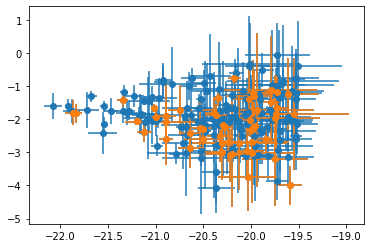

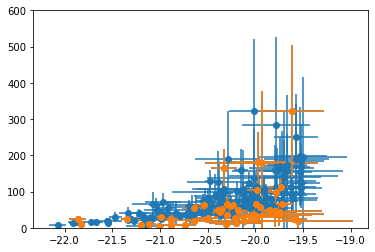

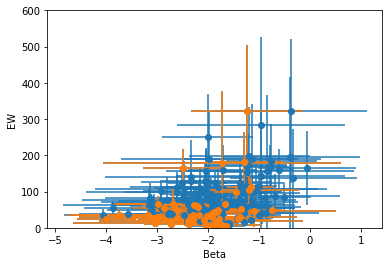

In [4]:
plt.errorbar(Muv,Beta,xerr=dMuv,yerr=dBeta,fmt='o')
plt.errorbar(Muv[Detection_type=="LAE"],Beta[Detection_type=="LAE"],xerr=dMuv[Detection_type=="LAE"],yerr=dBeta[Detection_type=="LAE"],fmt='o')
plt.show()
plt.errorbar(Muv,EW_obs,xerr=dMuv,yerr=dEW,fmt='o')
plt.errorbar(Muv[Detection_type=="LAE"],EW_obs[Detection_type=="LAE"],xerr=dMuv[Detection_type=="LAE"],yerr=dEW[Detection_type=="LAE"],fmt='o')
plt.ylim(0,600)
plt.show()
plt.errorbar(Beta,EW_obs,xerr=dBeta,yerr=dEW,fmt='o')
plt.errorbar(Beta[Detection_type=="LAE"],EW_obs[Detection_type=="LAE"],xerr=dBeta[Detection_type=="LAE"],yerr=dEW[Detection_type=="LAE"],fmt='o')
plt.ylim(0,600)
plt.xlabel("Beta")
plt.ylabel("EW")
plt.show()


In [5]:
def Likelihood(ew,dEW,Wo):
    """
    Likelihood : Probability of having a certain value of EW given the exponential parameters A and Wo

    Args:
        ew: Equivalent widths observed
        A : Parameter exponential (should depend on our other observables, such as uvslope and muv)
        Wo : Parameter exponential (should depend on our other observables, such as uvslope and muv)
    """
    A=1
    dEW_2 = dEW**2.
    p1 = (1. - A) * np.exp(-0.5 * ew**2./dEW_2) / np.sqrt(2.*np.pi) / dEW
    X  = (dEW_2/Wo - ew) / np.sqrt(2.) / dEW
    p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
    p = p1 + p2
    return p

def ParameterModel(physParams,mathParams):
    """
    ParameterModel: Given the physical parameters and the mathematical parameters, it returns the parameter of the model
    
    Input:
    - physParams: Physical parameters (Muv)
    - mathParams: Mathematical parameters (Constants of the model A and Wo)
    Output:
    - Parameter: Parameter of the model A or Wo
    """
    Muv,Beta=physParams
    cMuv,cBeta,cte= mathParams[0],mathParams[1],mathParams[2]
    Parameter   =   ((Muv+20)*cMuv) + ((Beta+2)*cBeta)  +   cte 
    #print(Parameter)
    return Parameter


def LikNoDet(wtab,dew,Wo):
        like = Likelihood(wtab,dew,Wo)
        return integrate.trapz(like,wtab)


def Posterior(ew,dew,physParams,mathParamsW):
    """
    

    """
    Wo=ParameterModel(physParams,mathParamsW)
    #probLike=self.Likelihood(ew,A,Wo)
    probLike=[]
    for i in range(0,len(Detection_type)):
        if Detection_type[i]=="LAE":
            p   =   Likelihood(ew[i],dew[i],Wo[i])
        if Detection_type[i]=="NonDetect":
            p   =   LikNoDet(wtab[i],dew[i],Wo[i])
        if np.isnan(p)==True:
            continue

        probLike.append(p)
        
    return np.array(probLike)

def log_prior(theta,physParams):
    # I can put priors here or in the equation in the BInf object 
    Wuv,Wb,Wc= theta
    W =   ParameterModel(physParams,[Wuv,Wb,Wc])
    #print(A,W)
    if  (W > 0.).all() and (W < 100.).all():
        return 0.0 

    return -np.inf

def log_likelihood(theta,y,yerr,physParams):
    Wuv,Wb,Wc= theta
    model = Posterior(y,yerr,physParams,[Wuv,Wb,Wc]) # Does thus have to be exp, so it gets outside the logaritm?

    return np.sum(np.log(model))


def log_probability(theta, y, yerr,Muv,Beta):
    #print(Muv,Beta)
    DrawnphysParams=[Muv,Beta]
    
    lp = log_prior(theta,DrawnphysParams)
    if not np.isfinite(lp):
        return -np.inf
    
    lL=log_likelihood(theta, y, yerr,DrawnphysParams)
    #print(lL)
    if np.isnan(lL)==True:
        return -np.inf
    else:
        return lp + lL

Muv_ready
Muv_ready
Muv_ready
Muv_ready
Muv_ready
Muv_ready
Muv_ready
Muv_ready
Muv_ready
Muv_ready
Muv_ready
Muv_ready
Muv_ready
Muv_ready
Muv_ready
Muv_ready
Muv_ready
Muv_ready
Muv_ready
Muv_ready


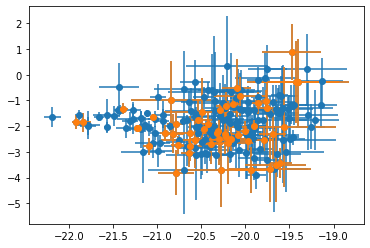

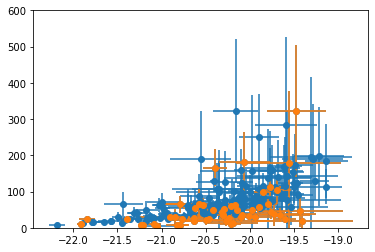

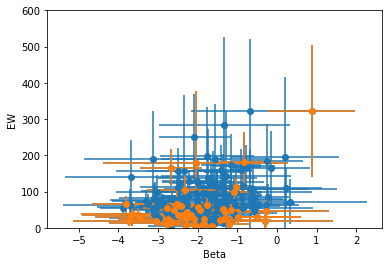

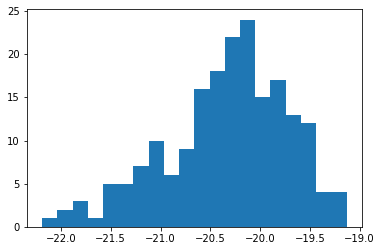

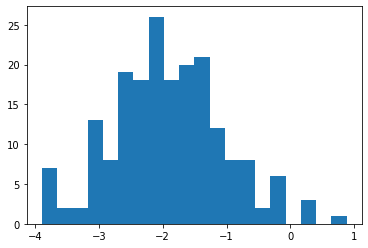

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 10/3000 [00:00<04:47, 10.39it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  1%|          | 16/3000 [00:01<04:57, 10.02it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  1%|▏         | 39/3000 [00:04<05:39,  8.72it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_

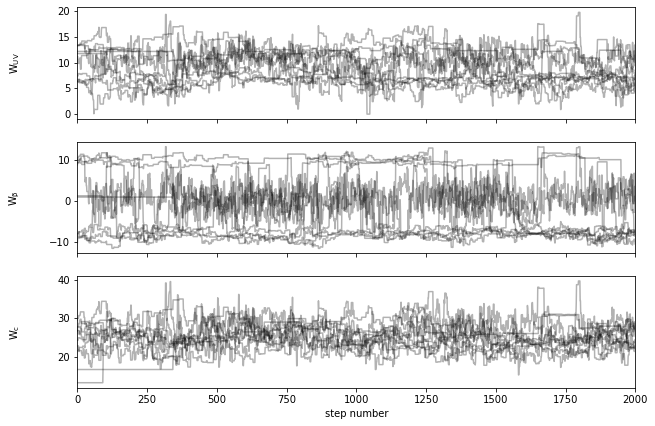

(20000, 3)


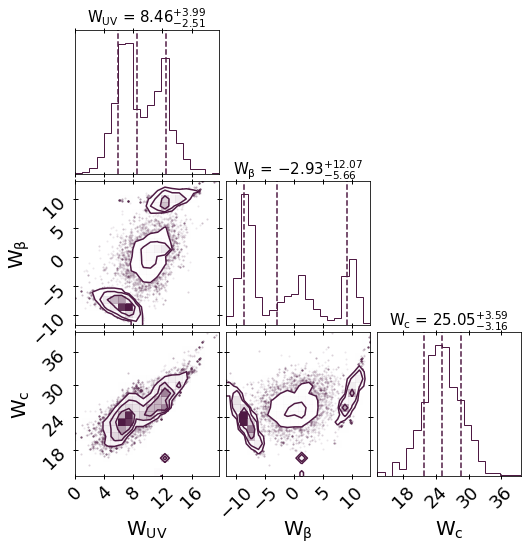

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

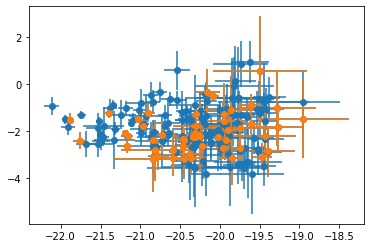

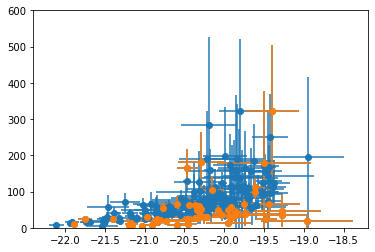

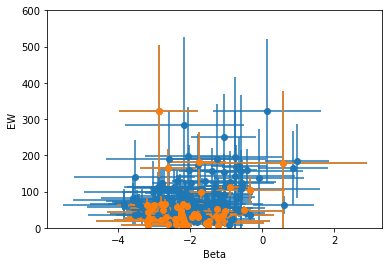

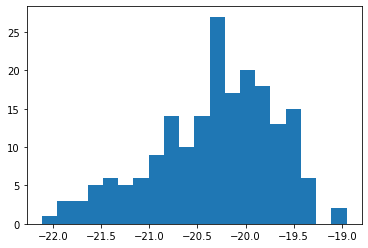

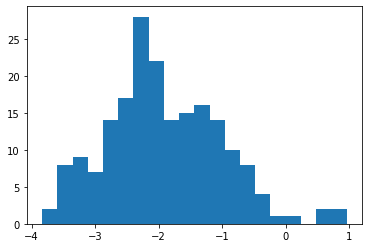

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 6/3000 [00:00<04:27, 11.18it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  1%|          | 24/3000 [00:02<04:18, 11.51it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
 14%|█▍        | 419/3000 [00:47<05:31,  7.78it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_

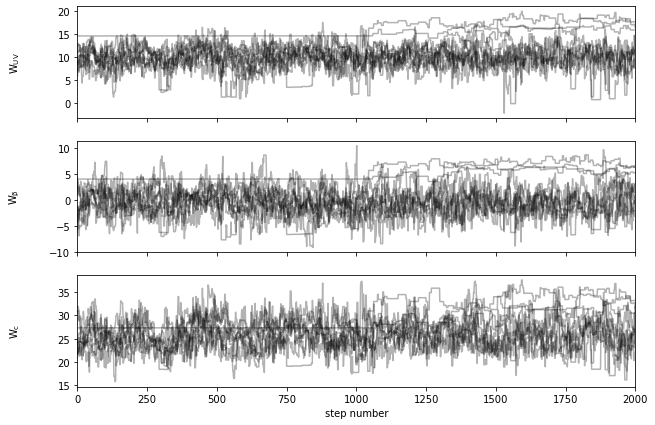

(20000, 3)


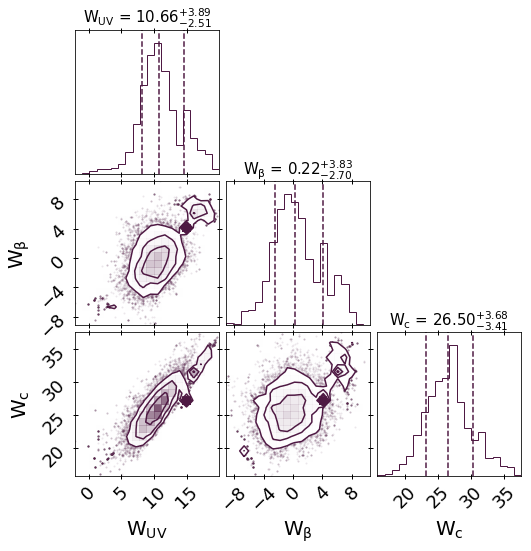

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

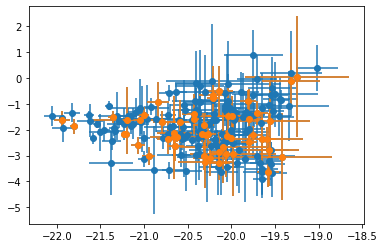

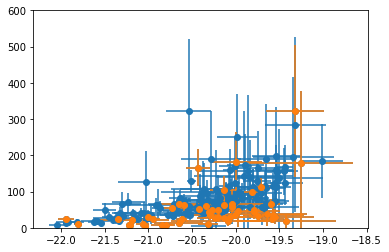

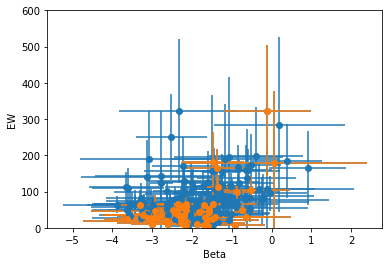

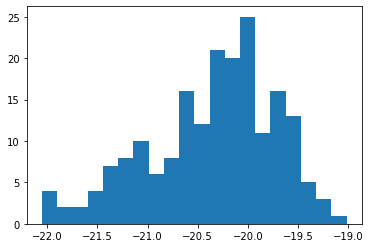

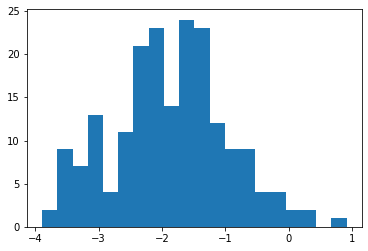

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 31/3000 [00:03<04:54, 10.09it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  5%|▌         | 160/3000 [00:17<05:30,  8.59it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  9%|▉         | 268/3000 [00:31<05:47,  7.86it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dE

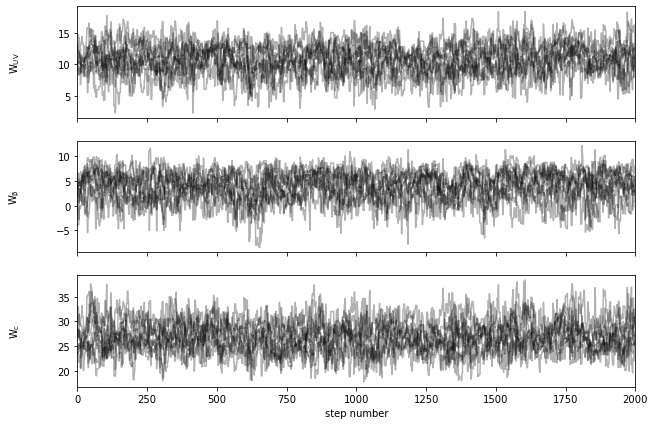

(20000, 3)


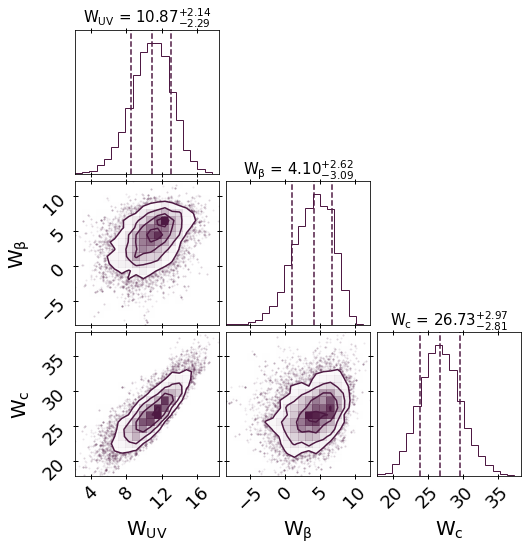

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

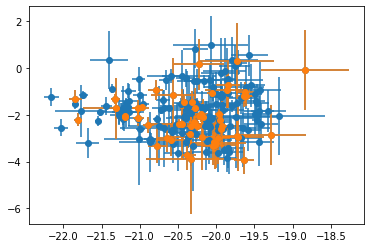

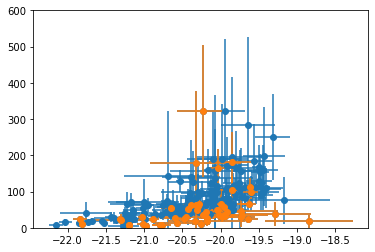

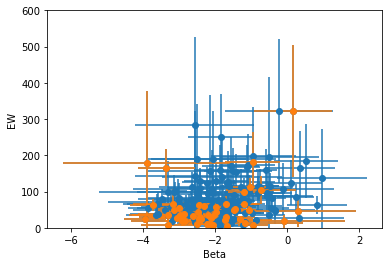

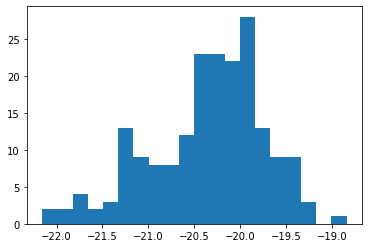

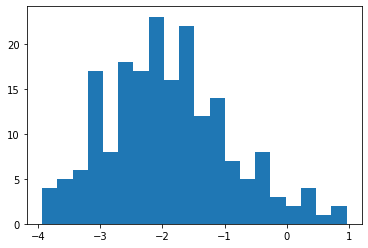

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 7/3000 [00:00<03:54, 12.74it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  2%|▏         | 49/3000 [00:04<04:38, 10.61it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  9%|▉         | 272/3000 [00:29<07:03,  6.44it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_

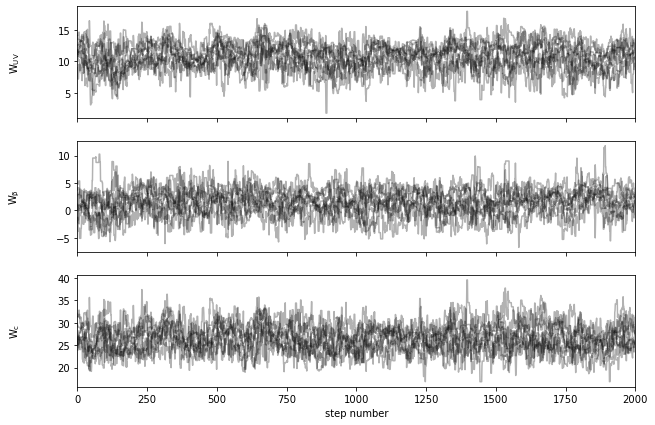

(18000, 3)


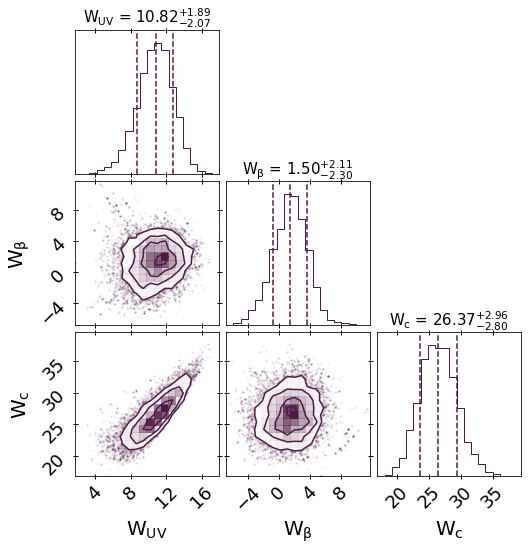

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

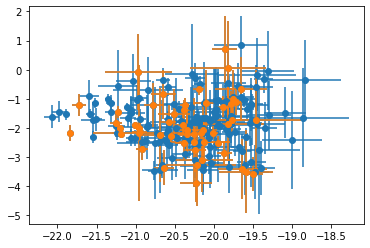

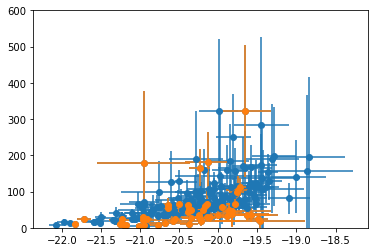

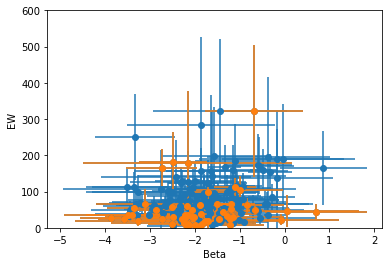

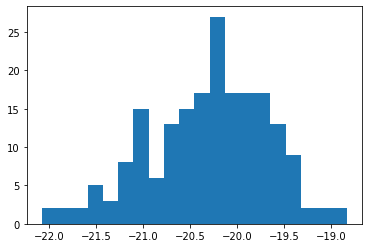

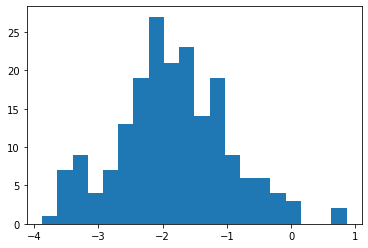

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 7/3000 [00:00<04:05, 12.20it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  0%|          | 9/3000 [00:00<04:10, 11.94it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  2%|▏         | 71/3000 [00:06<04:12, 11.60it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 

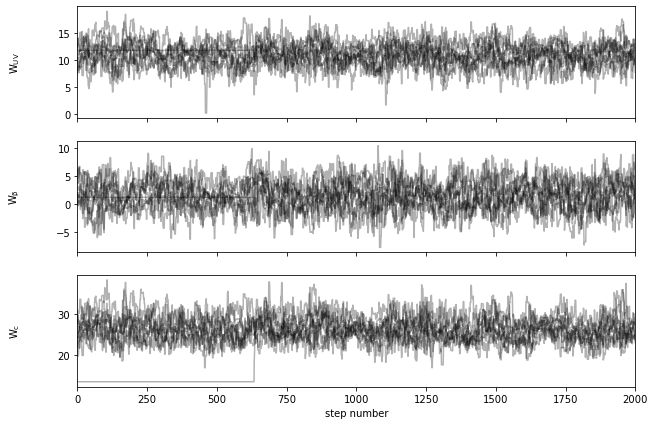

(20000, 3)


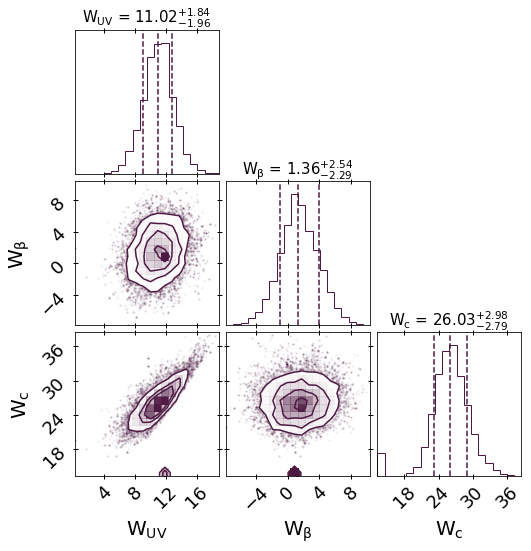

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

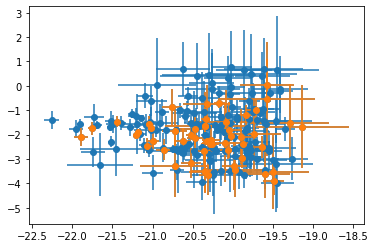

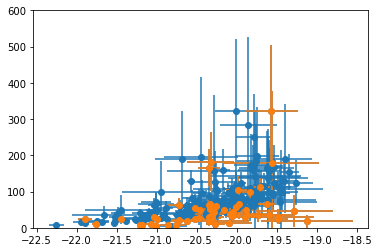

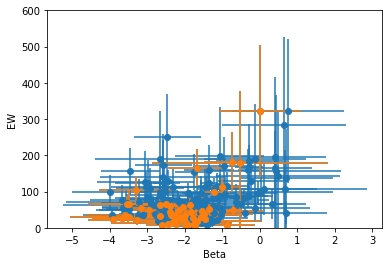

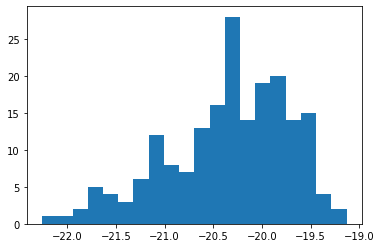

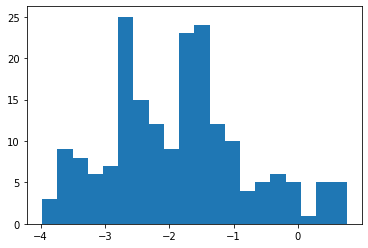

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 2/3000 [00:00<03:06, 16.11it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  1%|          | 25/3000 [00:01<03:46, 13.15it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  2%|▏         | 50/3000 [00:03<03:18, 14.86it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2

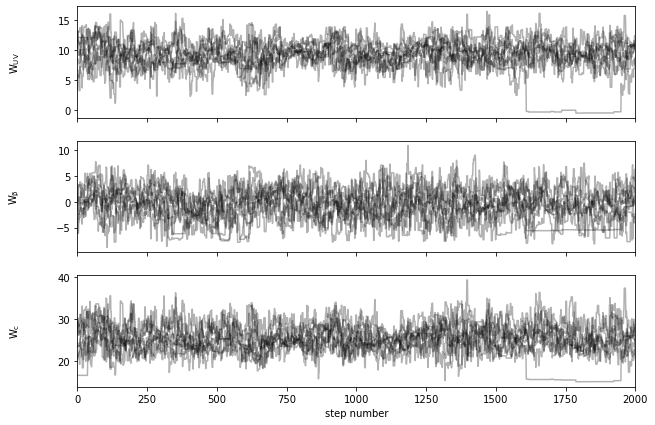

(18000, 3)


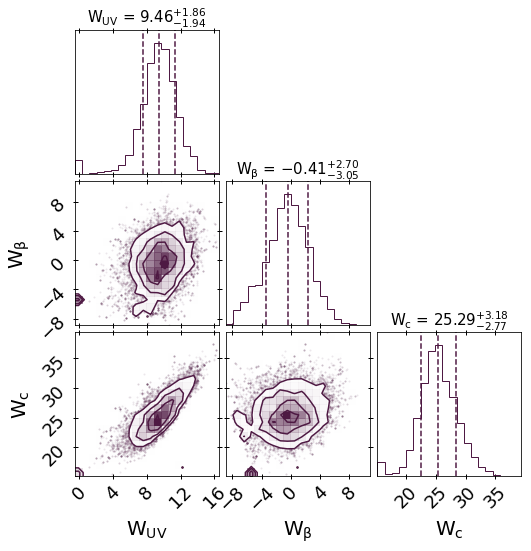

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

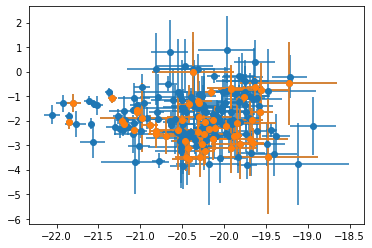

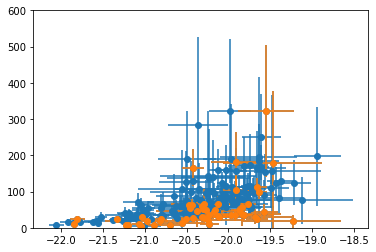

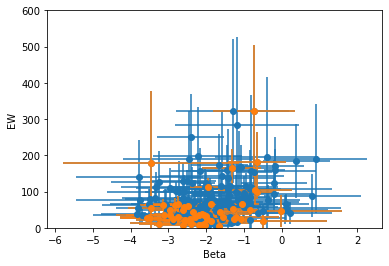

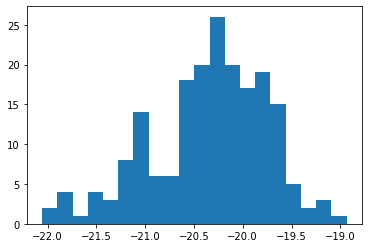

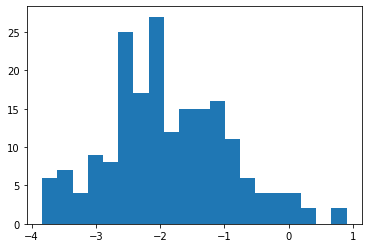

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 2/3000 [00:00<03:58, 12.56it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  1%|          | 16/3000 [00:01<04:33, 10.92it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
 16%|█▋        | 491/3000 [00:51<04:01, 10.40it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_

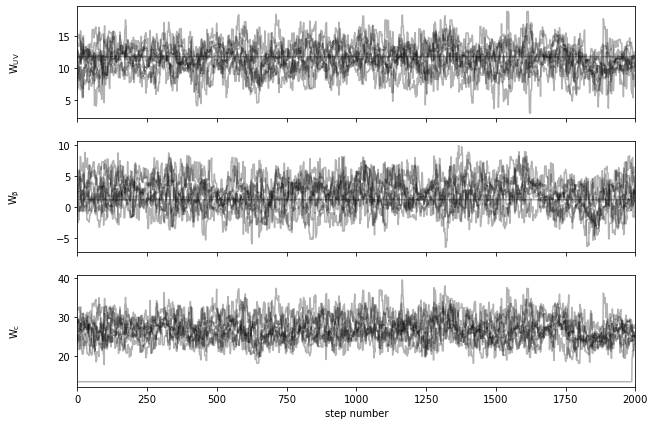

(20000, 3)


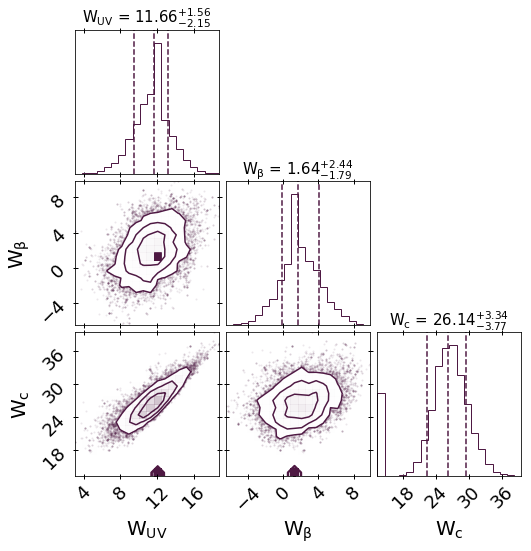

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

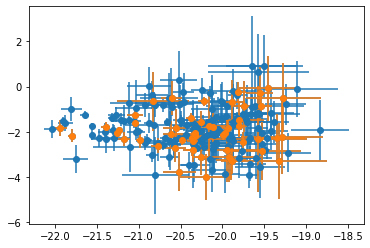

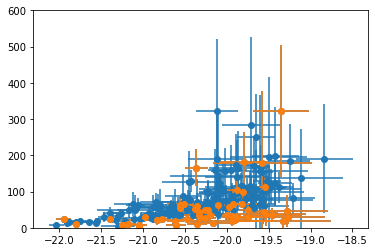

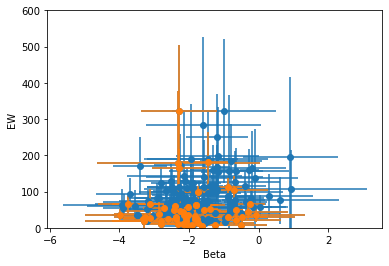

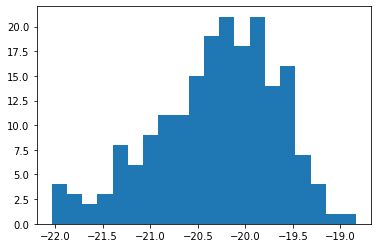

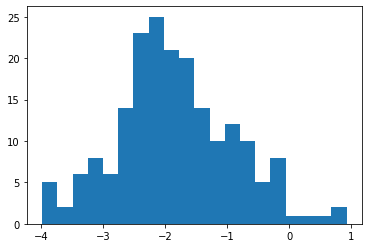

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 3/3000 [00:00<04:29, 11.13it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  6%|▌         | 173/3000 [00:15<04:26, 10.60it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
 96%|█████████▋| 2892/3000 [05:43<00:15,  6.86it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dE

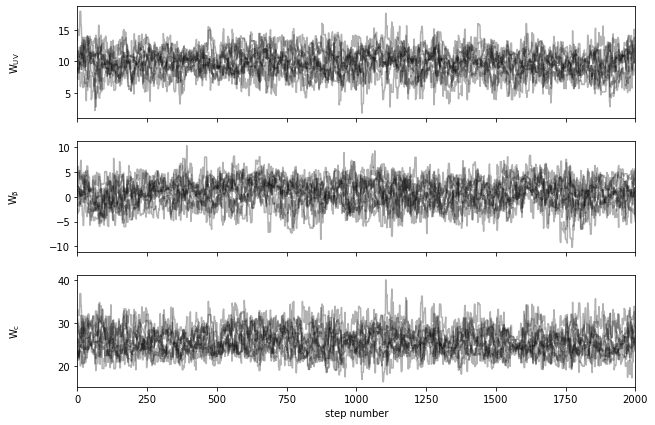

(20000, 3)


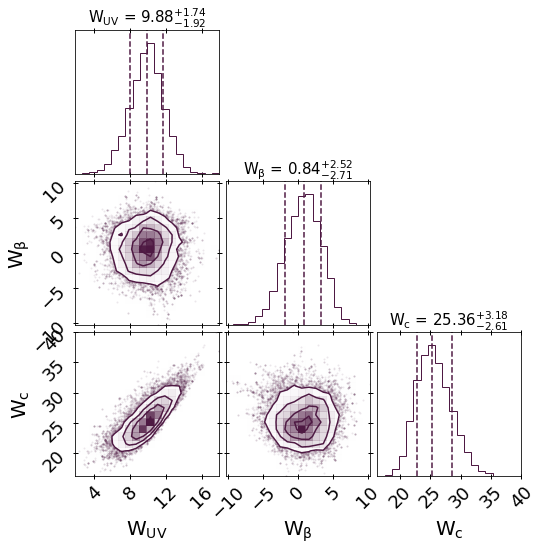

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

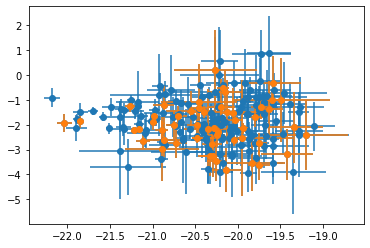

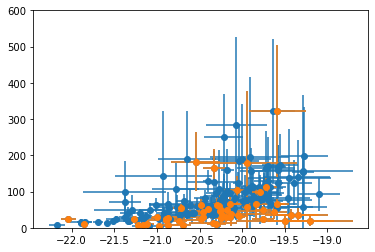

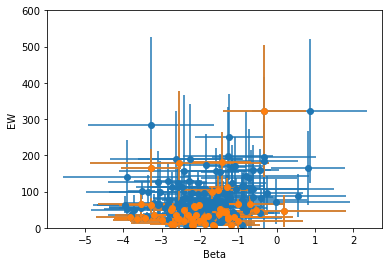

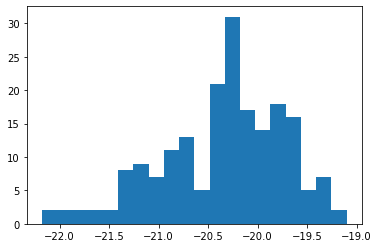

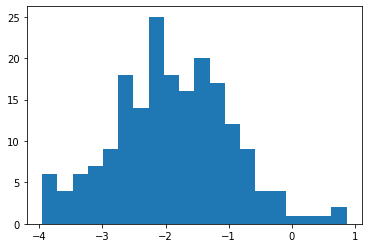

<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  6%|▌         | 183/3000 [00:17<04:04, 11.52it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
 63%|██████▎   | 1886/3000 [03:50<02:41,  6.89it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
100

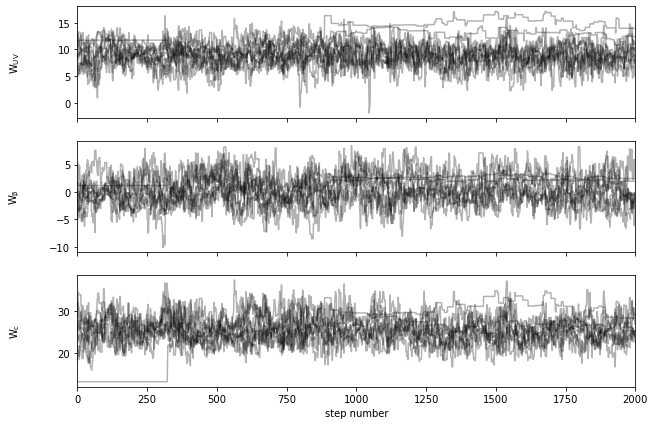

(20000, 3)


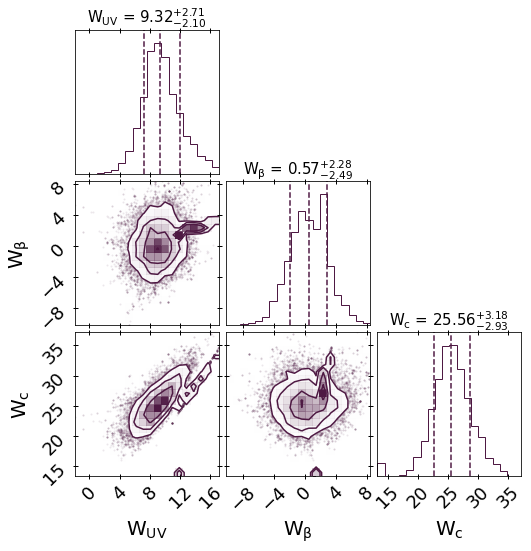

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

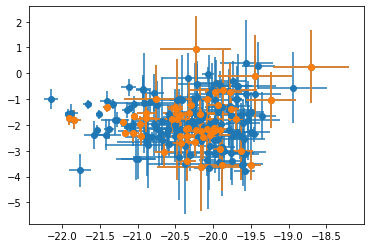

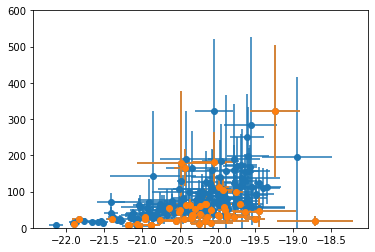

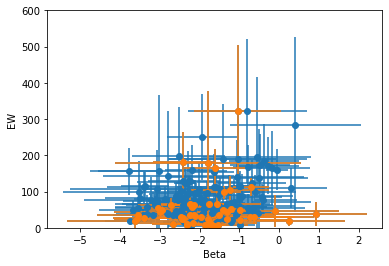

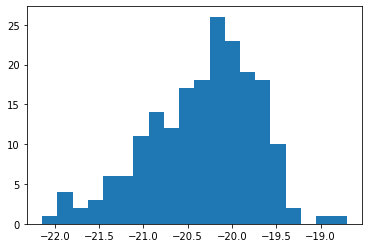

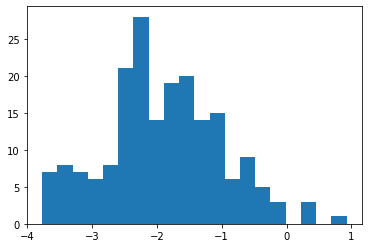

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  1%|▏         | 39/3000 [00:03<04:43, 10.43it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
 19%|█▉        | 579/3000 [01:10<05:02,  8.01it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
100%|

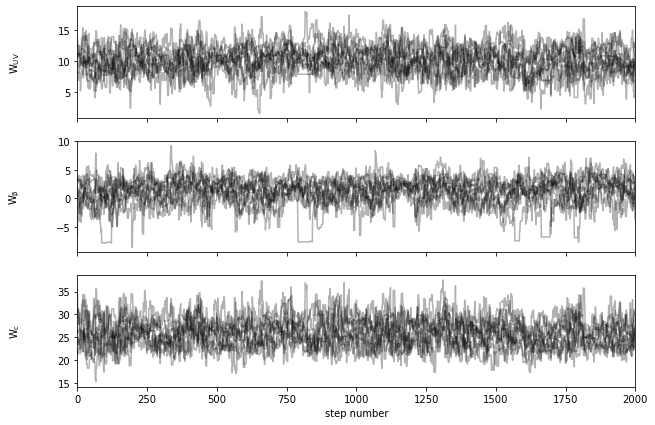

(20000, 3)


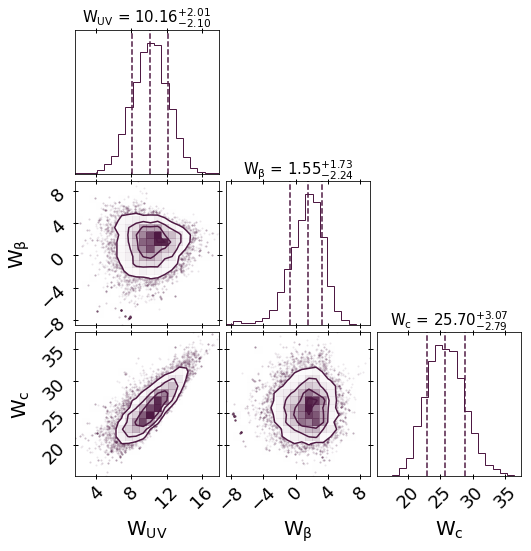

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

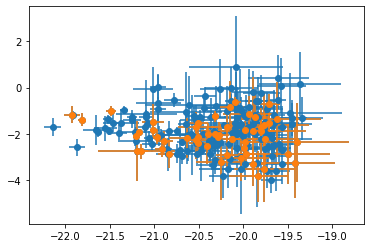

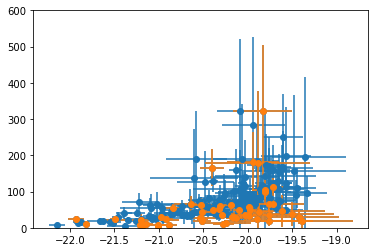

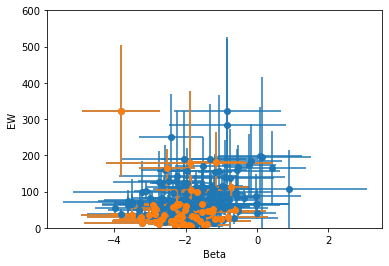

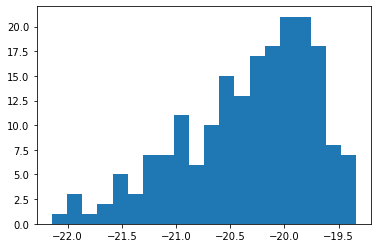

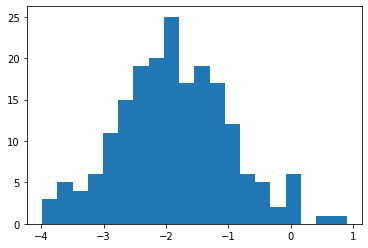

<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 18/3000 [00:01<04:41, 10.59it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  6%|▌         | 165/3000 [00:16<05:07,  9.22it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
 26%|

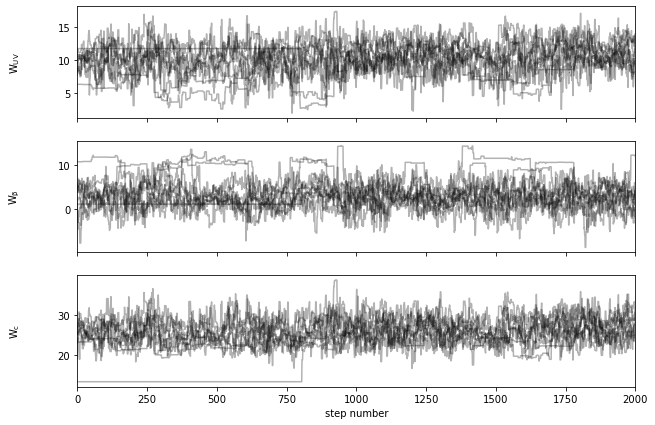

(20000, 3)


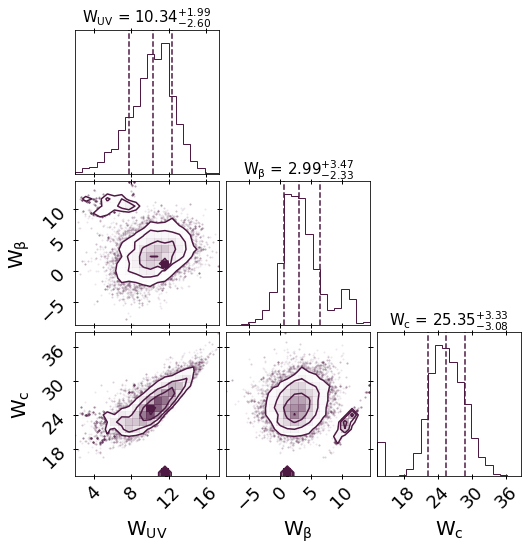

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

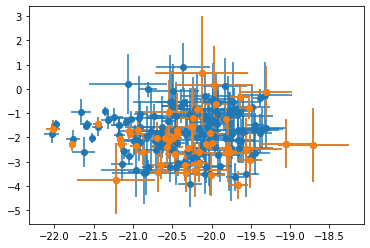

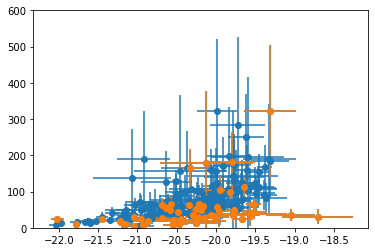

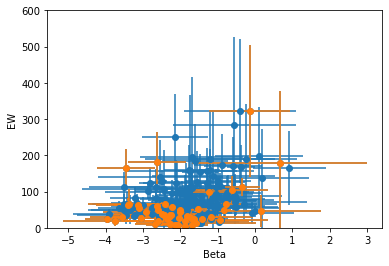

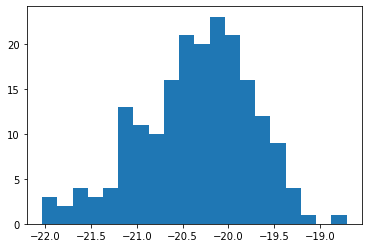

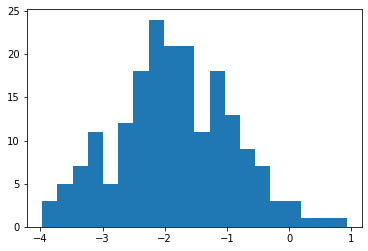

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 1/3000 [00:00<13:34,  3.68it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  6%|▌         | 166/3000 [00:18<05:51,  8.06it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
 70%|█

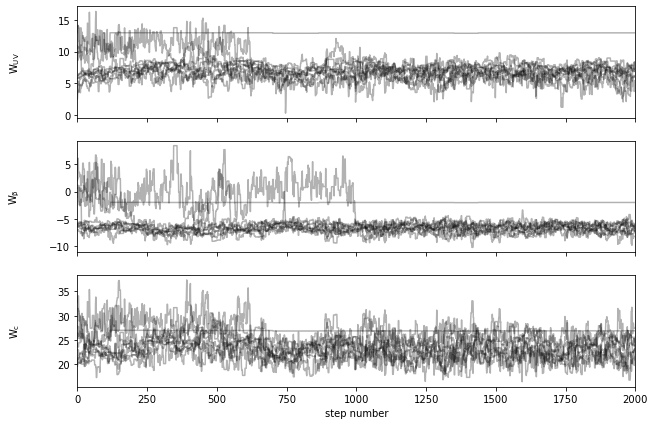

(20000, 3)


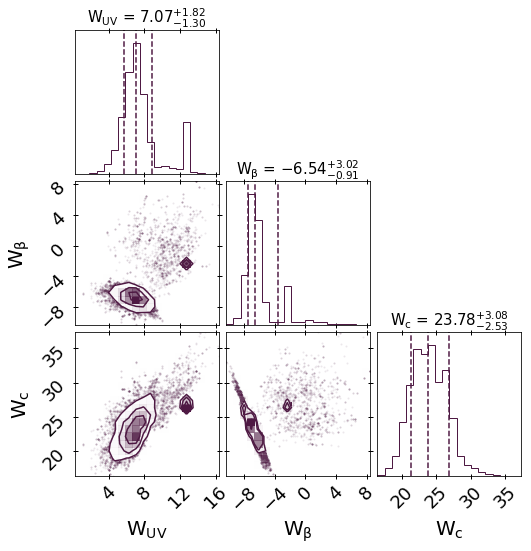

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

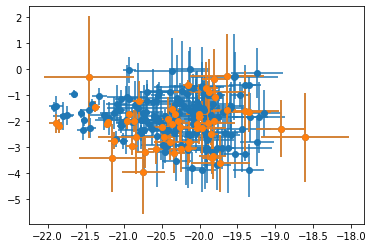

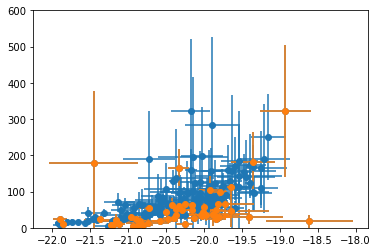

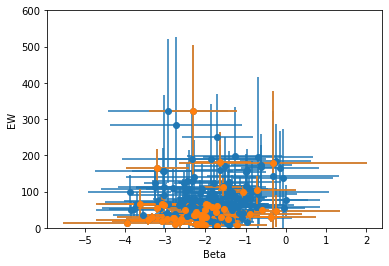

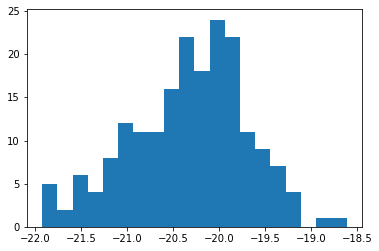

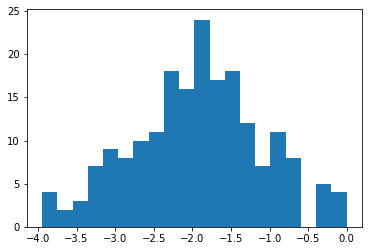

<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 17/3000 [00:01<08:03,  6.18it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  2%|▏         | 63/3000 [00:07<05:39,  8.65it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
 31%|█

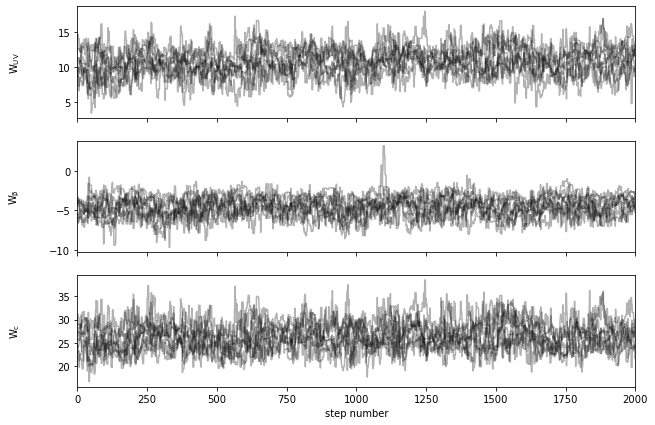

(18000, 3)


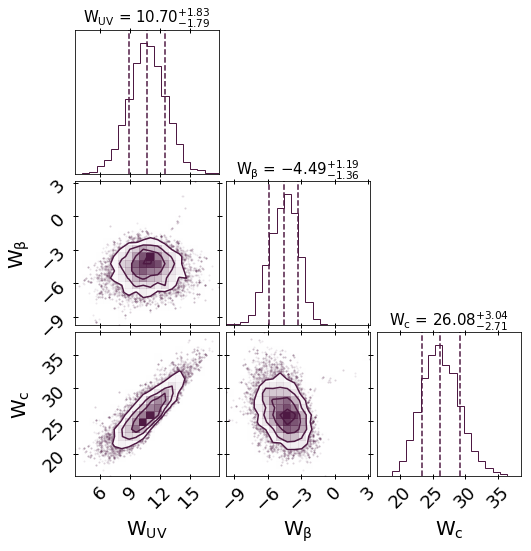

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

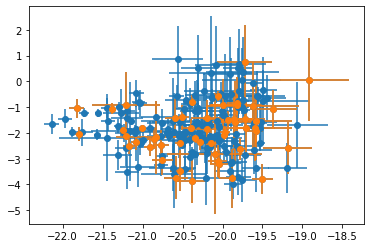

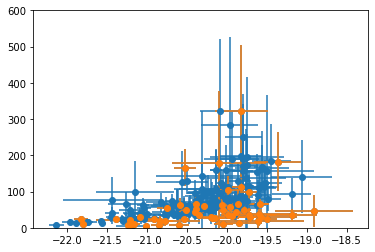

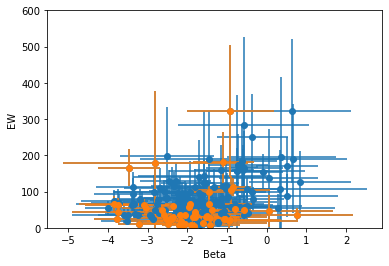

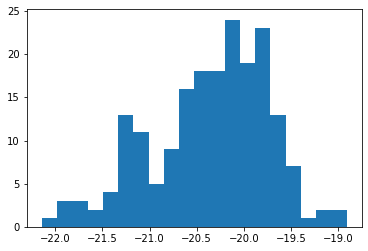

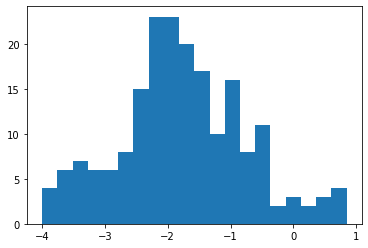

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 1/3000 [00:00<05:55,  8.45it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  2%|▏         | 52/3000 [00:06<05:07,  9.57it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
 76%|███████▌  | 2267/3000 [04:49<02:25,  5.05it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW

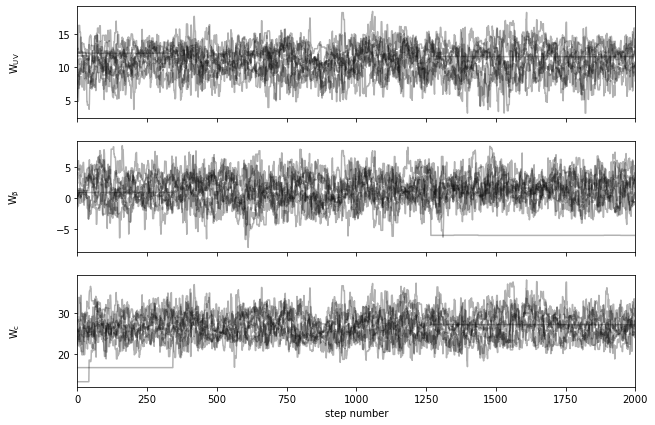

(20000, 3)


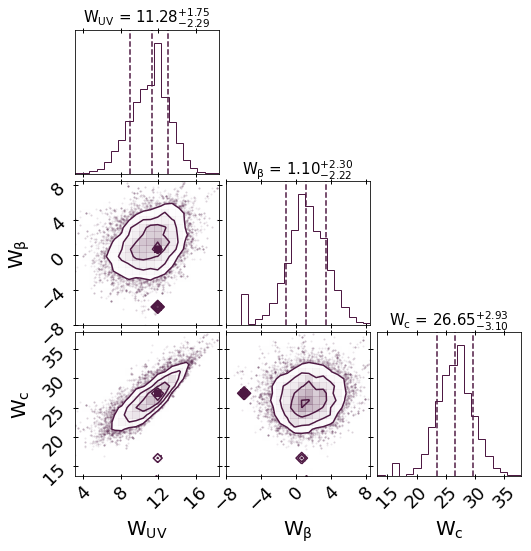

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

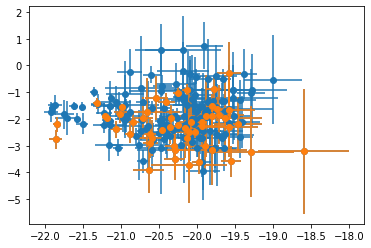

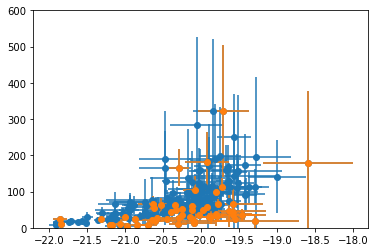

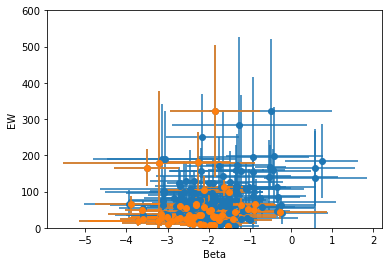

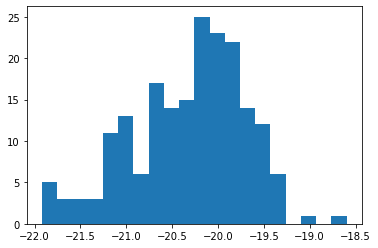

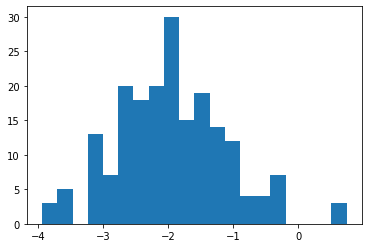

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 14/3000 [00:01<06:24,  7.77it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  4%|▍         | 135/3000 [00:20<08:33,  5.58it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  6%|▌         | 182/3000 [00:28<08:56,  5.26it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dE

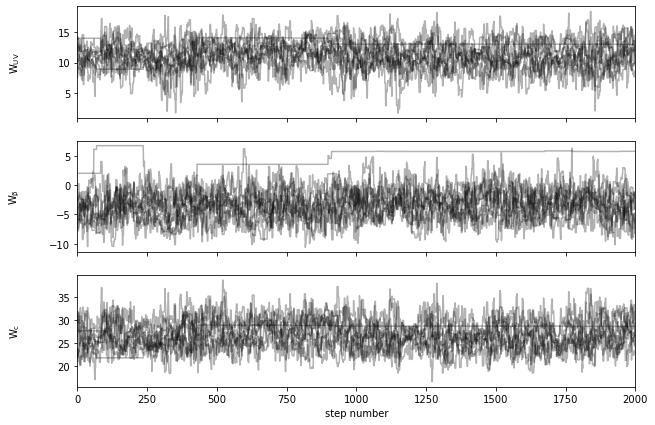

(20000, 3)


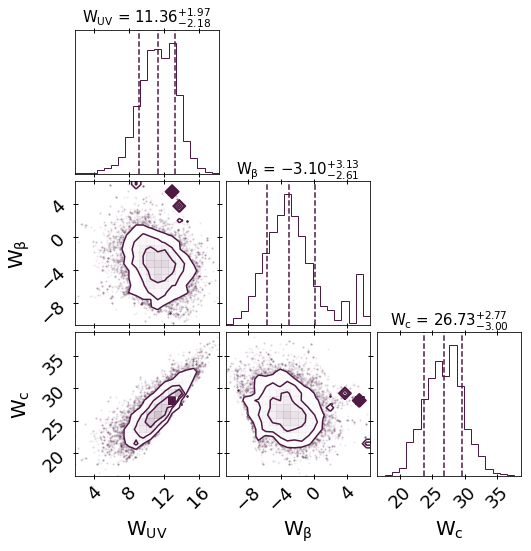

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

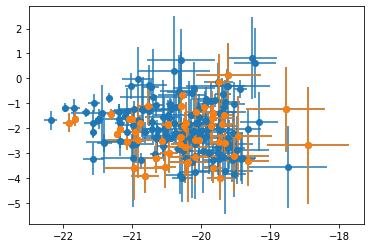

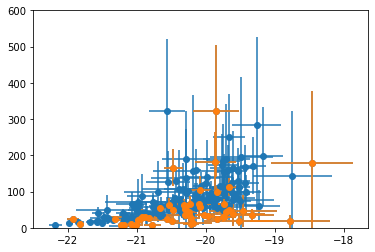

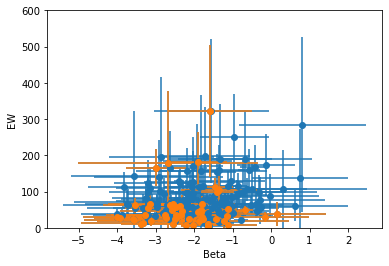

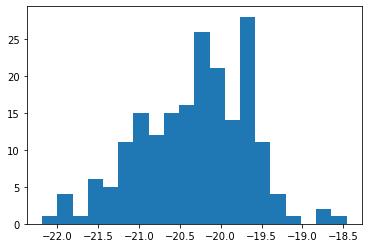

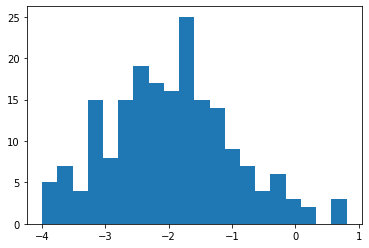

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 2/3000 [00:00<08:46,  5.70it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  2%|▏         | 67/3000 [00:07<05:53,  8.29it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
 30%|██▉       | 898/3000 [01:35<03:44,  9.38it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_

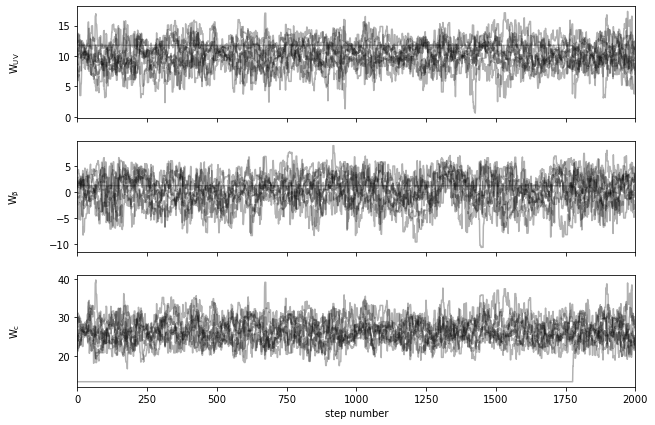

(20000, 3)


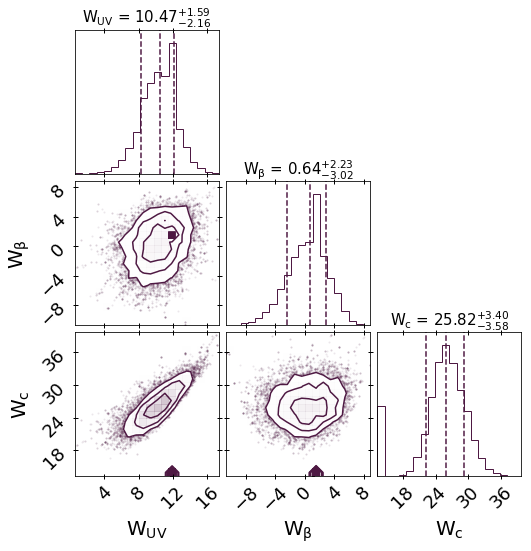

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

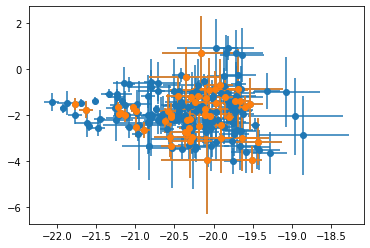

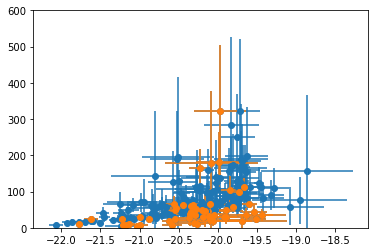

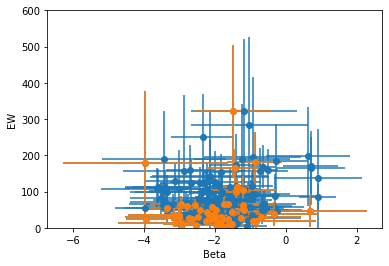

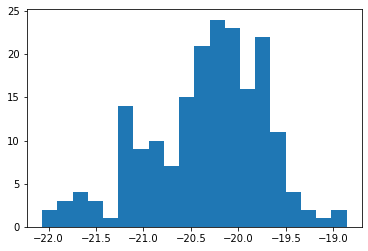

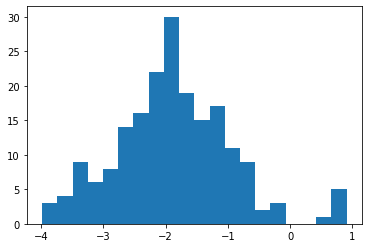

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 17/3000 [00:01<05:37,  8.83it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  1%|          | 31/3000 [00:03<07:26,  6.65it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  2%|▏         | 54/3000 [00:06<05:05,  9.65it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_

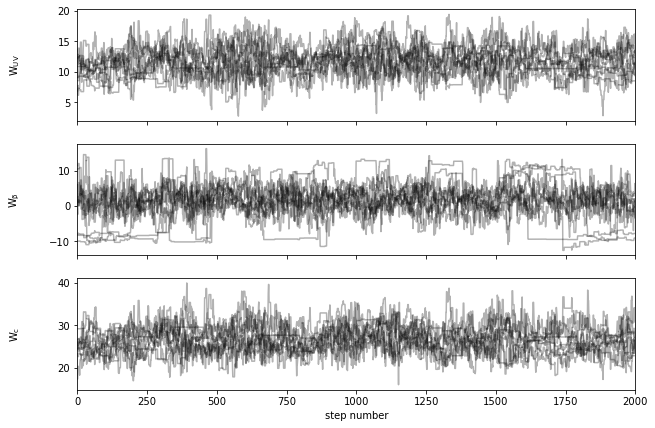

(20000, 3)


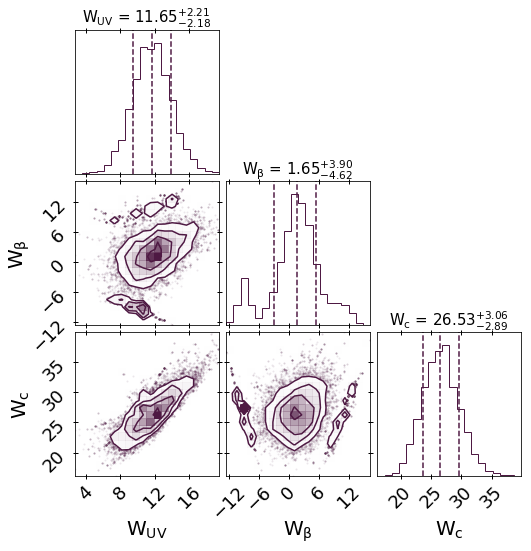

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

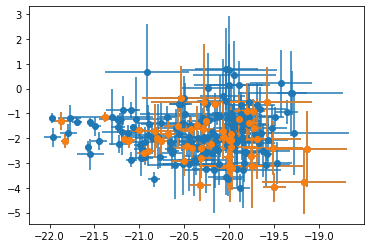

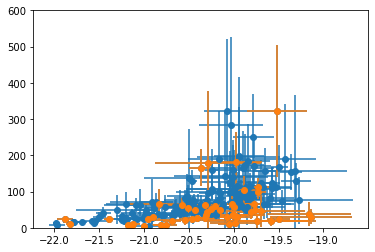

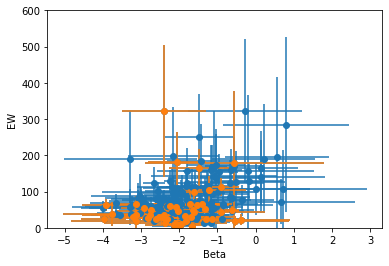

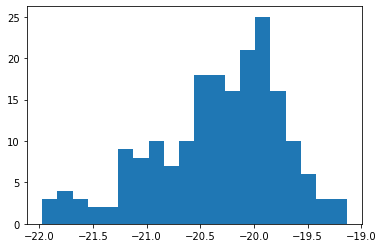

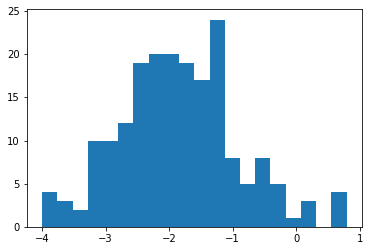

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 3/3000 [00:00<04:35, 10.89it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  8%|▊         | 239/3000 [00:28<06:28,  7.10it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
 86%|████████▌ | 2579/3000 [06:05<01:08,  6.12it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dE

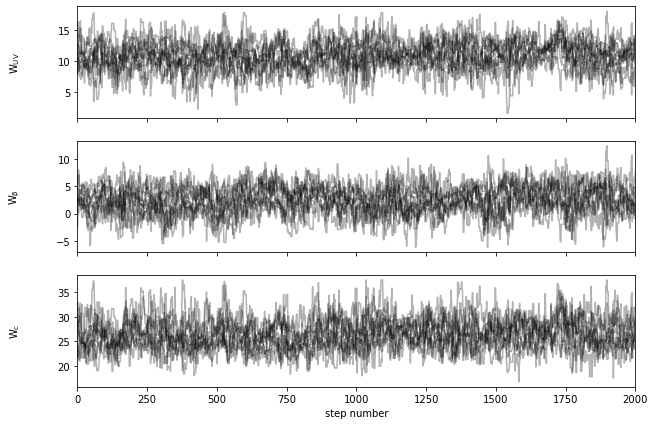

(20000, 3)


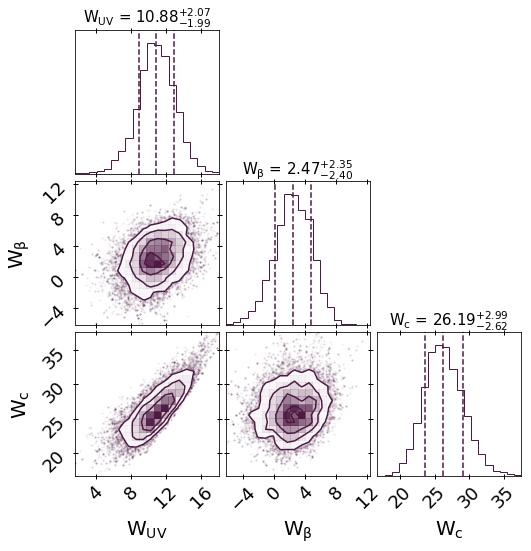

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

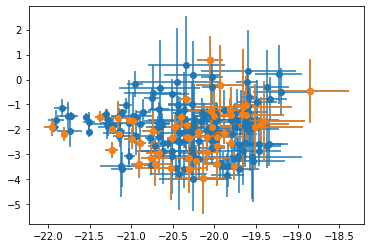

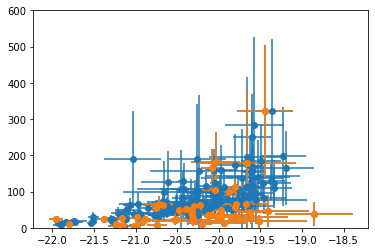

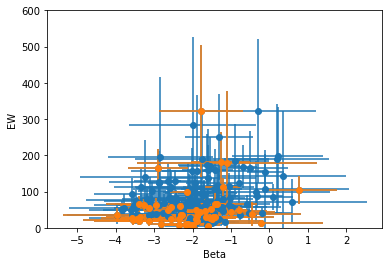

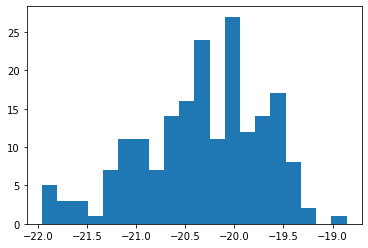

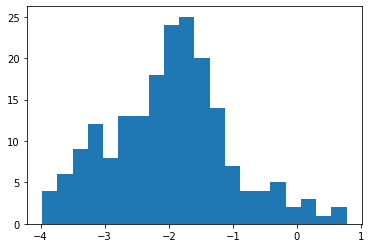

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 24/3000 [00:02<05:39,  8.77it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  1%|          | 37/3000 [00:04<04:56, 10.00it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  7%|▋         | 196/3000 [00:24<06:43,  6.95it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW

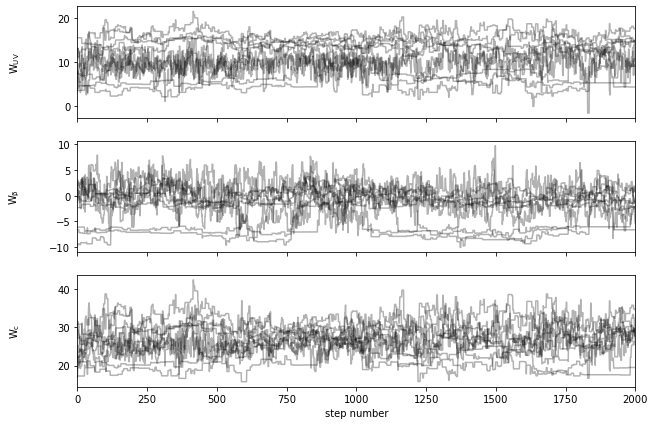

(20000, 3)


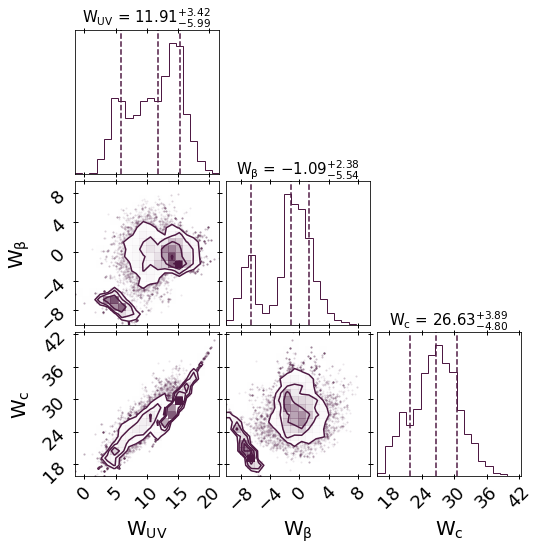

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

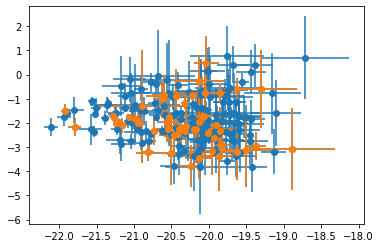

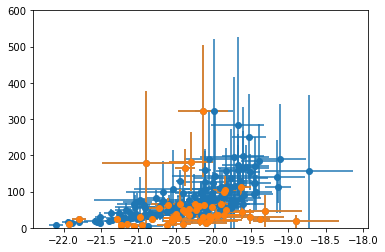

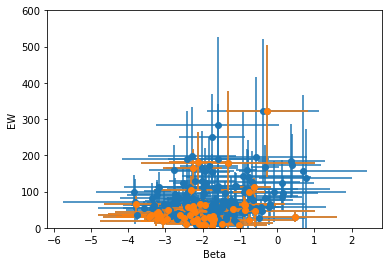

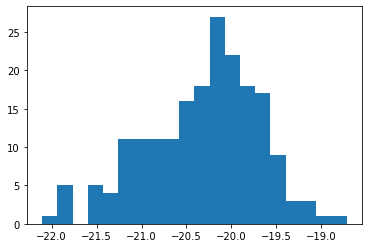

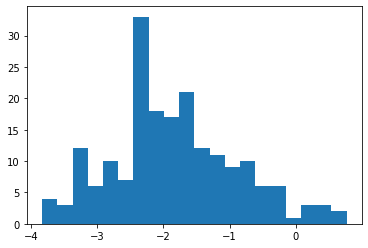

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 7/3000 [00:00<04:48, 10.36it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in exp
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
  2%|▎         | 75/3000 [00:07<04:30, 10.79it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: overflow encountered in multiply
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)*scipy.special.erfc(X)
 69%|██████▊   | 2060/3000 [04:03<02:19,  6.73it/s]<ipython-input-5-d3a8c721e25a>:14: RuntimeWarning: invalid value encountered in double_scalars
  p2 = 0.5 * A / Wo * np.exp(0.5*(dEW

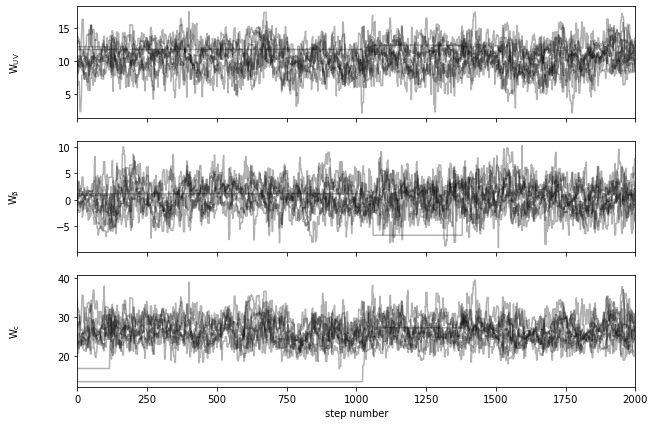

(20000, 3)


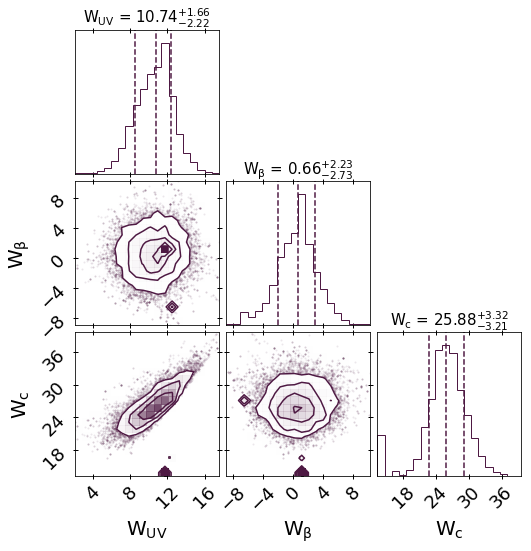

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:

Muv=np.array(Muv)
Beta=np.array(Beta)
dMuv=np.array(dMuv)
dBeta=np.array(dBeta)
EW_obs=np.array(EW_obs)
dEW=np.array(dEW)
steps=3000
nwalkers=10
inValuesW=[10,0,20]
dis=1000
inValues=inValuesW


pos = inValues+ [2,2,5] * np.random.randn(nwalkers,len(inValues) )
nwalkers, ndim = np.shape(pos)

runs=20
Muv_draws = []
Beta_draws = []

for iter in range(0,runs):
    tempM=[]
    tempB=[]
    for m,dm in zip(Muv,dMuv):
        new_m= np.random.normal(m,dm)
        while new_m < -23.5 or new_m > -18:
            new_m= np.random.normal(m,dm)
        tempM.append(new_m)
    Muv_draws.append(tempM)
    print("Muv_ready")
    for b,db in zip(Beta,dBeta):
        new_b= np.random.normal(b,db)
        while new_b < -4 or new_b > 1:
            new_b= np.random.normal(b,db)
        tempB.append(new_b)
    Beta_draws.append(tempB)



for iter in range(0,runs):

    Muv_i=np.array(Muv_draws[iter])
    Beta_i=np.array(Beta_draws[iter])
    plt.errorbar(Muv_i,Beta_i,xerr=dMuv,yerr=dBeta,fmt='o')
    plt.errorbar(Muv_i[Detection_type=="LAE"],Beta_i[Detection_type=="LAE"],xerr=dMuv[Detection_type=="LAE"],yerr=dBeta[Detection_type=="LAE"],fmt='o')
    plt.show()
    plt.errorbar(Muv_i,EW_obs,xerr=dMuv,yerr=dEW,fmt='o')
    plt.errorbar(Muv_i[Detection_type=="LAE"],EW_obs[Detection_type=="LAE"],xerr=dMuv[Detection_type=="LAE"],yerr=dEW[Detection_type=="LAE"],fmt='o')
    plt.ylim(0,600)
    plt.show()
    plt.errorbar(Beta_i,EW_obs,xerr=dBeta,yerr=dEW,fmt='o')
    plt.errorbar(Beta_i[Detection_type=="LAE"],EW_obs[Detection_type=="LAE"],xerr=dBeta[Detection_type=="LAE"],yerr=dEW[Detection_type=="LAE"],fmt='o')
    plt.ylim(0,600)
    plt.xlabel("Beta")
    plt.ylabel("EW")
    plt.show()
    plt.hist(Muv_i,bins=20)
    plt.show()
    plt.hist(Beta_i,bins=20)
    plt.show()
    
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(EW_obs,dEW,Muv_i,Beta_i)
    )
    sampler.run_mcmc(pos, steps, progress=True)



    labels = [r"W$_{\mathrm{UV}}$",r"W$_{\mathrm{\beta}}$",r"W$_{\mathrm{c}}$"]
    fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)
    samples = sampler.get_chain(discard=dis)
    logProb=sampler.get_log_prob(discard=dis)
    maskWalkers=[False if np.isinf(logProb[steps-dis-10,i]) else True for i in range(0,nwalkers)]
    samples=np.array([s[maskWalkers] for s in samples])
    for i in range(len(labels)):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")
    plt.show()



    ndim=len(labels)
    samples = sampler.get_chain(discard=dis)
    samples=np.array([s[maskWalkers] for s in samples])
    samples=samples.reshape(np.shape(samples)[0]*np.shape(samples)[1],np.shape(samples)[2])
    print(np.shape(samples))

    cmap=cmocean.sequential.Matter_3_r.mpl_colormap

    labels = [r"W$_{\mathrm{UV}}$",r"W$_{\mathrm{\beta}}$",r"W$_{\mathrm{c}}$"]

    fig = corner.corner(
        samples, labels=labels,quantiles=[.16,.50,.84],label_kwargs={"fontsize": 20},color=cmap(0.1), show_titles=True, title_kwargs={"fontsize": 15}
    )
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i in range(ndim):
        for j in range(ndim):
            ax = axes[i, j]
            ax.tick_params(axis='both', direction='inout', length=5, width=1., which='both', top=True, right=True, labelsize=18)


    #plt.savefig("/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/A-Project/E-Plots/MakeFigures/Figures/CornerPlot.png",dpi=300,bbox_inches='tight')
    plt.show()
    labels = ["W_{UV}","W_b","W_c"]

    results=[]
    r16,r84=[],[]
    for i in range(ndim):
        mcmc = np.percentile(samples[:, i], [16, 50, 84])
        results.append(mcmc[1])
        r16.append(mcmc[0])
        r84.append(mcmc[2])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))
        
    np.save("Samples3_19-5/samples"+str(iter)+".npy",samples)


In [ ]:
%load_ext autoreload
%autoreload

mParamsA=results[:2]
mParamsW=results[2:]

#print("Initial : ")
#print(mockParamsA[0]*np.nanmedian(BInf.Muv)+mockParamsA[1]*np.nanmedian(BInf.UVslope)+mockParamsA[2])
#print(mockParamsW[0]*np.nanmedian(BInf.Muv) + mockParamsW[1]*np.nanmedian(BInf.UVslope) +mockParamsW[2])

#,probSets,As,Ws=BInf.GenerateMockDataConvolved(mockParamsA,mockParamsW)
#for prob in probSets[:]:
#    plt.plot(x,prob,color="black",alpha=0.05)
#    #plt.ylim(-0.001,0.05)
#    #plt.xlim(-100,300)
#    plt.xlabel("EW [A]")
#plt.plot(x,prob,color="black",alpha=0.05,label="TrueAs")
#TrueAs=np.array(As)
#TrueWs=np.array(Ws)




x,probSets,As,Ws=BInf.GenerateMockDataConvolved_real(mParamsA,mParamsW)
for prob in probSets[:]:
    plt.plot(x,prob,color="red",alpha=0.05)
    plt.ylim(-0.001,0.05)
    plt.xlim(-50,300)
    plt.xlabel("EW [A]")
    plt.title("results")
plt.hist(BInf.EW_obs,bins=10,density=True,range=[-50,300])
plt.plot(x,prob,color="red",alpha=0.05,label="ResultAs")
plt.legend()
plt.show()

resultAs=np.array(As)
resultWs=np.array(Ws)
mParamsA=r16[:2]
mParamsW=r16[2:]
x,probSets,As,Ws=BInf.GenerateMockDataConvolved_real(mParamsA,mParamsW)
r16As=np.array(As)
r16Ws=np.array(Ws)
mParamsA=r84[:2]
mParamsW=r84[2:]
x,probSets,As,Ws=BInf.GenerateMockDataConvolved_real(mParamsA,mParamsW)
r84As=np.array(As)
r84Ws=np.array(Ws)

print("Median True values : ")
#print("A : ",np.median(TrueAs))
#print("W0 : ",np.median(TrueWs))

print("Median Result values : ")
print("A : ",np.median(resultAs))
print("W0 : ",np.median(resultWs))

#plt.hist(TrueAs,label="True",range=[0.4,1])
plt.hist(As,label="result",alpha=0.8,range=[0.4,1])
plt.xlabel("A")
plt.legend()
plt.show()

#plt.hist(TrueWs,label="True",range=[30,100])
plt.hist(Ws,label="result",alpha=0.8,range=[30,100])
plt.xlabel("W")
plt.legend()
plt.show()



In [ ]:
plt.errorbar(TrueWs,resultWs,yerr=resultWs-r16Ws,fmt="o")
plt.plot([40,90],[40,90],color="black")
plt.xlabel("True W")
plt.ylabel("Result W")
plt.show()

plt.errorbar(TrueAs,resultAs,yerr=resultAs-r16As,fmt="o")
plt.plot([0.4,1],[0.4,1],color="black")
plt.xlabel("True A")
plt.ylabel("Result A")
plt.show()

In [ ]:
results

In [ ]:
import imageio
from PIL import Image

results_transposed = np.transpose(results)
plt.rcParams["figure.figsize"] = (7.5,7.)
sns.set_theme(style="ticks",font_scale=1.8)

#x,probSets1,As,Ws=BInf.GenerateMockDataConvolved(mockParamsA,mockParamsW)
#plt.scatter(As,Ws)
x2,probSets2,Asr,Wsr=BInf.GenerateMockDataConvolved_real([np.median(results_transposed[0]),np.median(results_transposed[1])],[np.median(results_transposed[2]),np.median(results_transposed[3])])
plt.scatter(Asr,Wsr)
plt.show()
# Create a list to store the images
images = []

# Loop through the probSets1 and probSets2
delay = 1.5

# Loop through the probSets1 and probSets2
for p2, muv,a,w,ar,wr in zip( probSets2, BInf.Muv,As,Ws,Asr,Wsr):
    # Create a new figure
    fig, ax = plt.subplots()
    
    # Plot p1 and p2
    ax.plot(x, p2,lw=5, label='Result')
    ax.set_xlim(-50, 200)
    #ax.set_ylim(0, 0.013)
    # Add text for Muv in the top right corner
    ax.text(0.95, 0.85, f'Muv: {np.round(muv,1)}', transform=ax.transAxes, ha='right', va='top')
    ax.text(0.95, 0.75, f'A: {np.round(a,2)}', transform=ax.transAxes, ha='right', va='top')
    ax.text(0.95, 0.65, f'W: {np.round(w,1)}', transform=ax.transAxes, ha='right', va='top')
    #ax.text(0.95, 0.65, f'Ares: {ar}', transform=ax.transAxes, ha='right', va='top')
    #ax.text(0.95, 0.55, f'Wres: {wr}', transform=ax.transAxes, ha='right', va='top')
    # Save the figure as an image
    plt.legend()
    ax.set_xlabel(r"EW$_{\mathrm{Ly\alpha}}$ [A]")
    ax.set_ylabel(r"P(EW$_{\mathrm{Ly\alpha}}$|Muv)")
    plt.tight_layout()

    fig.canvas.draw()
    image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    images.append(image)
    plt.clf()
 
# Save the images as a GIF with a slower frame rate
imageio.mimsave('plots_real.gif', images, duration=delay)


In [ ]:
steps=1000
nwalkers=10

#mockParamsA=[0.12,3.2]
#mockParamsW=[8,230]

inValuesA=[0.,0.9]
inValuesW=[0,50]

inValues=inValuesA+inValuesW

All_results=[]
for i in range(0,1):
    pos = inValues+ [0.01,0.2,1,30] * np.random.randn(nwalkers,len(inValues) )
    nwalkers, ndim = np.shape(pos)

    #mp_pool = multiproc.ProcessPool(nodes=8)
    #with mp_pool as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(EW_obs , dEW,)
    )
    sampler.run_mcmc(pos, steps, progress=True)


    dis=200
    labels = ["Auv","Ac","Wuv","Wc"]
    fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)
    samples = sampler.get_chain(discard=dis)
    logProb=sampler.get_log_prob(discard=dis)
    maskWalkers=[False if np.isinf(logProb[steps-dis-10,i]) else True for i in range(0,nwalkers)]
    samples=np.array([s[maskWalkers] for s in samples])
    for i in range(len(labels)):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")
    plt.show()


    ndim=len(labels)
    samples = sampler.get_chain(discard=dis)
    samples=np.array([s[maskWalkers] for s in samples])
    samples=samples.reshape(np.shape(samples)[0]*np.shape(samples)[1],np.shape(samples)[2])
    print(np.shape(samples))


    fig = corner.corner(
        samples, labels=labels,quantiles=[.16,.50,.84],truths=[*mockParamsA,*mockParamsW]
    )
    plt.show()

    results=[]
    r16,r84=[],[]
    for i in range(ndim):
        mcmc = np.percentile(samples[:, i], [16, 50, 84])
        results.append(mcmc[1])
        r16.append(mcmc[0])
        r84.append(mcmc[2])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))

    All_results.append(results)

In [ ]:
%load_ext autoreload
%autoreload

mParamsA=results[:2]
mParamsW=results[2:]

#print("Initial : ")
#print(mockParamsA[0]*np.nanmedian(BInf.Muv)+mockParamsA[1]*np.nanmedian(BInf.UVslope)+mockParamsA[2])
#print(mockParamsW[0]*np.nanmedian(BInf.Muv) + mockParamsW[1]*np.nanmedian(BInf.UVslope) +mockParamsW[2])

x1,probSets1,As,Ws=BInf.GenerateMockDataConvolved(mockParamsA,mockParamsW)
for prob in probSets1[:]:
    plt.plot(x,prob,color="black",alpha=0.05)
    #plt.ylim(-0.001,0.05)
    #plt.xlim(-100,300)
    plt.xlabel("EW [A]")
plt.plot(x,prob,color="black",alpha=0.8,label="TrueAs")
TrueAs=np.array(As)
TrueWs=np.array(Ws)




x2,probSets2,As,Ws=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
for prob in probSets2[:]:
    plt.plot(x,prob,color="red",alpha=0.05)
    #plt.ylim(-0.001,0.05)
    #plt.xlim(-100,300)
    plt.xlabel("EW [A]")
    plt.title("results")
plt.plot(x,prob,color="red",alpha=0.8,label="ResultAs")
plt.legend()
plt.show()




import imageio
from PIL import Image

# Create a list to store the images
images = []

# Loop through the probSets1 and probSets2
for p1, p2 in zip(probSets1, probSets2):
    # Create a new figure
    fig, ax = plt.subplots()
    
    # Plot p1 and p2
    ax.plot(x, p1)
    ax.plot(x, p2)
    ax.set_xlim(-10, 200)
    
    # Save the figure as an image
    fig.canvas.draw()
    image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    images.append(image)
    plt.close(fig)

# Save the images as a GIF
imageio.mimsave('plots.gif', images)

resultAs=np.array(As)
resultWs=np.array(Ws)
mParamsA=r16[:2]
mParamsW=r16[2:]
x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
r16As=np.array(As)
r16Ws=np.array(Ws)
mParamsA=r84[:2]
mParamsW=r84[2:]
x,probSets,As,Ws=BInf.GenerateMockDataConvolved(mParamsA,mParamsW)
r84As=np.array(As)
r84Ws=np.array(Ws)

print("Median True values : ")
print("A : ",np.median(TrueAs))
print("W0 : ",np.median(TrueWs))

print("Median Result values : ")
print("A : ",np.median(resultAs))
print("W0 : ",np.median(resultWs))

plt.hist(TrueAs,label="True",range=[0.4,1])
plt.hist(As,label="result",alpha=0.8,range=[0.4,1])
plt.xlabel("A")
plt.legend()
plt.show()

plt.hist(TrueWs,label="True",range=[30,100])
plt.hist(Ws,label="result",alpha=0.8,range=[30,100])
plt.xlabel("W")
plt.legend()
plt.show()


In [ ]:
plt.errorbar(TrueWs,resultWs,yerr=resultWs-r16Ws,fmt="o")
plt.plot([40,90],[40,90],color="black")
plt.xlabel("True W")
plt.ylabel("Result W")
plt.show()

plt.errorbar(TrueAs,resultAs,yerr=resultAs-r16As,fmt="o")
plt.plot([0.4,1],[0.4,1],color="black")
plt.xlabel("True A")
plt.ylabel("Result A")
plt.show()

In [ ]:
for iiii in range(0,50):    
    steps=3000
    nwalkers=10

    #mockParamsA=[0.12,3.2]
    #mockParamsW=[8,230]

    inValuesA=[0.,0.9]
    inValuesW=[0,50]

    inValues=inValuesA+inValuesW


    pos = inValues+ [0.01,0.2,1,30] * np.random.randn(nwalkers,len(inValues) )
    nwalkers, ndim = np.shape(pos)

    #mp_pool = multiproc.ProcessPool(nodes=8)
    #with mp_pool as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(EW_obs , dEW,)
    )
    sampler.run_mcmc(pos, steps, progress=True)




    dis=1000
    labels = ["Auv","Ac","Wuv","Wc"]
    fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)
    samples = sampler.get_chain(discard=dis)
    logProb=sampler.get_log_prob(discard=dis)
    maskWalkers=[False if np.isinf(logProb[steps-dis-10,i]) else True for i in range(0,nwalkers)]
    samples=np.array([s[maskWalkers] for s in samples])
    for i in range(len(labels)):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")
    plt.show()



    ndim=len(labels)
    samples = sampler.get_chain(discard=dis)
    samples=np.array([s[maskWalkers] for s in samples])
    np.save("results/samples"+str(iiii)+".npy",samples)
    samples=samples.reshape(np.shape(samples)[0]*np.shape(samples)[1],np.shape(samples)[2])
    print(np.shape(samples))


    fig = corner.corner(
        samples, labels=labels,quantiles=[.16,.50,.84],truths=[*mockParamsA,*mockParamsW]
    )
    plt.show()

    results=[]
    r16,r84=[],[]
    for i in range(ndim):
        mcmc = np.percentile(samples[:, i], [16, 50, 84])
        results.append(mcmc[1])
        r16.append(mcmc[0])
        r84.append(mcmc[2])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))


    np.save("results_uplim/results"+str(iiii)+".npy",results)

In [ ]:
import glob
resultados=glob.glob("results_uplim/results*.npy")

results=[]
for res in resultados:
    results.append(np.load(res))

resultWs=[]
resultAs=[]
for r in results:
    Amuv,Ac=r[0],r[1]
    Wmuv,Wc=r[2],r[3]                                                                                                      
    __,__,As,Ws=BInf.GenerateMockDataConvolved([Amuv,Ac],[Wmuv,Wc])
    resultWs.append(Ws)
    resultAs.append(As)

In [ ]:

for rW,rA in zip(resultWs,resultAs):
    plt.errorbar(TrueWs,rW,fmt="-",alpha=0.5,color="black")
    plt.plot([40,90],[40,90],color="black",ls="--")
    plt.xlabel("True W")
    plt.ylabel("Result W")
plt.show()
for rW,rA in zip(resultWs,resultAs):
    plt.errorbar(TrueAs,rA,alpha=0.5,fmt="-",color="black")
    plt.plot([0.4,1],[0.4,1],color="black",ls="--")
    plt.xlabel("True A")
    plt.ylabel("Result A")
plt.show()


In [ ]:
mParamsA=results[:2]
mParamsW=results[2:]

#print("Initial : ")
#print(mockParamsA[0]*np.nanmedian(BInf.Muv)+mockParamsA[1]*np.nanmedian(BInf.UVslope)+mockParamsA[2])
#print(mockParamsW[0]*np.nanmedian(BInf.Muv) + mockParamsW[1]*np.nanmedian(BInf.UVslope) +mockParamsW[2])

x,probSets,As,Ws=BInf.GenerateMockData(mockParamsA,mockParamsW)
for prob in probSets[:]:
    plt.plot(x,prob,color="black",alpha=0.05)
    #plt.ylim(-0.001,0.05)
    #plt.xlim(-100,300)
    plt.xlabel("EW [A]")
plt.plot(x,prob,color="black",alpha=0.05,label="TrueAs")
TrueAs=np.array(As)
TrueWs=np.array(Ws)

In [ ]:
%load_ext autoreload
%autoreload

import imageio
from PIL import Image

results=[]
for res in resultados:
    results.append(np.load(res))

results_transposed = np.transpose(results)

x,probSets1,As,Ws=BInf.GenerateMockData(mockParamsA,mockParamsW)
x2,probSets2,As,Ws=BInf.GenerateMockData([np.median(results_transposed[0]),np.median(results_transposed[1])],[np.median(results_transposed[2]),np.median(results_transposed[3])])

# Create a list to store the images
images = []

# Set the delay between frames (in seconds)
delay = 0.5

# Loop through the probSets1 and probSets2
for p1, p2, muv in zip(probSets1, probSets2, BInf.Muv):
    # Create a new figure
    fig, ax = plt.subplots()
    
    # Plot p1 and p2
    ax.plot(x, p1,color="black",ls="--")
    ax.plot(x, p2)
    ax.set_xlim(-10, 200)
    #ax.set_ylim(0, 0.013)
    # Add text for Muv in the top right corner
    ax.text(0.95, 0.95, f'Muv: {muv}', transform=ax.transAxes, ha='right', va='top')
    
    # Save the figure as an image
    fig.canvas.draw()
    image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    images.append(image)
    plt.show()

# Save the images as a GIF with a slower frame rate
imageio.mimsave('plots_uplim.gif', images, duration=delay)



In [ ]:
%load_ext autoreload
%autoreload

def OGLikelihood(ew,A,Wo):
    return ((A/Wo)*np.exp(-ew/Wo)*np.heaviside(ew,0.0) + (1-A)*DeltaFunc(ew) )

x2,probSets2,As,Ws=BInf.GenerateMockData([0.106,2.91],[10.29,280.22])
for p1, p2, muv in zip(probSets1[:10], probSets2[:10], BInf.Muv[:10]):
    #print(10.28*muv+280.22)
    #print(0.106*muv+2.91)
    print((0.106*muv+2.91)/(10.28*muv+280.22)*np.exp(-0.1/(10.28*muv+280.22)))
    fig, ax = plt.subplots()
    
    ax.plot(x, p1,color="black",ls="--")
    ax.plot(x, p2)
    ax.plot(x2, OGLikelihood(x2,0.73,63.55))


    ax.set_xlim(-10, 200)
    ax.set_ylim(0, 0.013)
    ax.axhline(0.0105, color='red')
    ax.text(0.95, 0.95, f'Muv: {muv}', transform=ax.transAxes, ha='right', va='top')
    ax.text(0.95, 0.75, f'A: {0.106*muv+2.91}', transform=ax.transAxes, ha='right', va='top')
plt.show()


In [ ]:
0.106/10.28

In [ ]:

for p1, p2, muv in zip(probSets1[:], probSets2[:], BInf.Muv[:]):
    #print(10.28*muv+280.22)
    #print(0.106*muv+2.91)
    plt.scatter((0.106*muv+2.91),(10.28*muv+280.22),color="black")



plt.scatter(TrueAs,TrueWs,color="blue")

x = [0.4, 1]
y = [35, 35 + (8/0.12 * (1 - 0.4))]

plt.plot(x, y, color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

x = [0, 1]
y = [0, 100]

plt.plot(x, y, 'r--')
plt.xlabel('x')
plt.ylabel('y')
plt.title('1-to-1 Line')
plt.xlim(0, 1)
plt.ylim(0, 100)
plt.show()
